# Evaluation scores



example: <br>
higher log probability ==> predicted class
if [score 0]=-2 and [score 1]=-3 then it means that the predicted class is class 0 <br>
[score] = -2+3 = 1 > 0 --> class 0
<br>
###########
<br>
if [score 0]=-3 and [score 1]=-2 then it means that the predicted class is class 1 <br>
[score] = -3+2 = -1 < 0 --> class 1

***
## Load the scores

In [3]:
import csv
import re
import sys

import pandas as pd
from src.utils import *
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve, auc

In [34]:
# paths to csv score files
probs_clean_csv = '../eval/prob_resnet_spec_eval.csv'
probs_0dot0_csv = '../eval/prob_resnet_spec_eval_FGSM_0dot0.csv'
probs_1dot0_csv = '../eval/prob_resnet_spec_eval_FGSM_1dot0.csv'
probs_2dot0_csv = '../eval/prob_resnet_spec_eval_FGSM_2dot0.csv' 
probs_3dot0_csv = '../eval/prob_resnet_spec_eval_FGSM_3dot0.csv'

# check the lengths
probs_clean = pd.read_csv(probs_clean_csv, header=0, engine='python')
probs_0dot0 = pd.read_csv(probs_0dot0_csv, header=0, engine='python')
probs_1dot0 = pd.read_csv(probs_1dot0_csv, header=0, engine='python')
probs_2dot0 = pd.read_csv(probs_2dot0_csv, header=0, engine='python')
probs_3dot0 = pd.read_csv(probs_3dot0_csv, header=0, engine='python')

if len(probs_clean) == len(probs_0dot0) == len(probs_1dot0) == len(probs_2dot0) == len(probs_3dot0):
    print(f'Lengths are okay: {len(probs_clean)}')
else:
    sys.exit('Lengths are not okay')

Lengths are okay: 71237


In [35]:
len(probs_0dot0)

71237

In [36]:
# ground truth file of evaluation dataset (ASVSpoof2019)
config_path = '../config/residualnet_train_config.yaml'
config = read_yaml(config_path)
df_eval = pd.read_csv(os.path.join('..', config['df_eval_path']))

In [38]:
df_eval[:3]

,Unnamed: 0,path,label
0,0,/nas/public/dataset/asvspoof2019/LA/ASVspoof20...,1
1,1,/nas/public/dataset/asvspoof2019/LA/ASVspoof20...,1
2,2,/nas/public/dataset/asvspoof2019/LA/ASVspoof20...,1


***
## Extract PREDICTED labels in the same order given by df_eval_19!

In [39]:
def extract_id(file_path):
    match = re.search(r'LA_E_(\d+)', file_path)
    if match:
        return match.group(1)
    return None
    
    
def pred_probabilities(file2_path):
    # read df_eval_19
    file1_path = '../data/df_eval_19.csv'
    
    file1_ids = []
    with open(file1_path, 'r') as file1:
        csv_reader = csv.reader(file1)
        for row in csv_reader:
            file_id = extract_id(row[1])
            if file_id:
                file1_ids.append(file_id)
    
    # read second file and store data in a dictionary
    file2_data = {}
    with open(file2_path, 'r') as file2:
        csv_reader = csv.reader(file2)
        for row in csv_reader:
            file_id = extract_id(row[0])
            if file_id:
                file2_data[file_id] = (float(row[1]), float(row[2]))
                
    output_array = []
    for file_id in file1_ids:
        if file_id in file2_data:
            col2, col3 = file2_data[file_id]
            output_array.append(0 if col2>col3 else 1)
                
    return output_array

***
## Accuracies

In [40]:
# the score values .csv uses a space as a delimiter between the file path and the score

# def convert_probs_to_labels(csv_file):
#     binary_list = []
#     
#     with open(csv_file, 'r') as file:
#         reader = csv.reader(file)
#         next(reader) # skip the header
#         for line in reader:
#             val_1 = float(line[1])
#             val_2 = float(line[2])
#             
#             try:
#                 if val_1 > val_2:
#                     binary_list.append(0)
#                 else:
#                     binary_list.append(1)
#             except ValueError:
#                 pass
#         
#     return binary_list

In [41]:
pred_labels_clean = pred_probabilities(file2_path=probs_clean_csv)
pred_labels_0dot0 = pred_probabilities(file2_path=probs_0dot0_csv)
pred_labels_1dot0 = pred_probabilities(file2_path=probs_1dot0_csv)
pred_labels_2dot0 = pred_probabilities(file2_path=probs_2dot0_csv)
pred_labels_3dot0 = pred_probabilities(file2_path=probs_3dot0_csv)

In [42]:
pred_labels_clean[:10]

[0, 1, 1, 1, 1, 0, 1, 0, 1, 0]

In [43]:
# get the GT labels
GT_labels = df_eval.iloc[:, -1].tolist()

### Unbalanced accuracy

In [44]:
unb_acc_clean = accuracy_score(y_true=GT_labels, y_pred=pred_labels_clean)
unb_acc_0dot0 = accuracy_score(y_true=GT_labels, y_pred=pred_labels_0dot0)
unb_acc_1dot0 = accuracy_score(y_true=GT_labels, y_pred=pred_labels_1dot0)
unb_acc_2dot0 = accuracy_score(y_true=GT_labels, y_pred=pred_labels_2dot0)
unb_acc_3dot0 = accuracy_score(y_true=GT_labels, y_pred=pred_labels_3dot0)

print(f'The unbalanced acc for clean eval set is {unb_acc_clean*100:.2f}%\n'
      f'The unbalanced acc for epsilon = 0.0 set is {unb_acc_0dot0*100:.2f}%\n'
      f'The unbalanced acc for epsilon = 1.0 set is {unb_acc_1dot0*100:.2f}%\n'
      f'The unbalanced acc for epsilon = 2.0 set is {unb_acc_2dot0*100:.2f}%\n'
      f'The unbalanced acc for epsilon = 3.0 set is {unb_acc_3dot0*100:.2f}%')


The unbalanced acc for clean eval set is 77.14%
The unbalanced acc for epsilon = 0.0 set is 76.58%
The unbalanced acc for epsilon = 1.0 set is 41.52%
The unbalanced acc for epsilon = 2.0 set is 22.92%
The unbalanced acc for epsilon = 3.0 set is 11.86%


### Balanced accuracy

In [47]:
bal_acc_clean = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_clean)
bal_acc_0dot0 = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_0dot0)
bal_acc_1dot0 = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_1dot0)
bal_acc_2dot0 = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_2dot0)
bal_acc_3dot0 = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_3dot0)

print(f'The balanced acc for clean eval set is {bal_acc_clean*100:.2f}%\n'
      f'The balanced acc for epsilon = 0.0 set is {bal_acc_0dot0*100:.2f}%\n'
      f'The balanced acc for epsilon = 1.0 set is {bal_acc_1dot0*100:.2f}%\n'
      f'The balanced acc for epsilon = 2.0 set is {bal_acc_2dot0*100:.2f}%\n'
      f'The balanced acc for epsilon = 3.0 set is {bal_acc_3dot0*100:.2f}%')

The balanced acc for clean eval set is 84.21%
The balanced acc for epsilon = 0.0 set is 84.36%
The balanced acc for epsilon = 1.0 set is 43.81%
The balanced acc for epsilon = 2.0 set is 13.89%
The balanced acc for epsilon = 3.0 set is 6.63%


***
## ROC curve and AUC

In [48]:
def create_prob_pos_class_list(csv_file):
    probs_pos_class = []
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader) # skip the header
        for row in reader:
            val = float(row[2]) # negative
            probs_pos_class.append(val)
    return probs_pos_class

In [49]:
positive_class_probs = create_prob_pos_class_list(probs_clean_csv)
positive_class_probs_1dot0 = create_prob_pos_class_list(probs_1dot0_csv)
positive_class_probs_2dot0 = create_prob_pos_class_list(probs_2dot0_csv)
positive_class_probs_3dot0 = create_prob_pos_class_list(probs_3dot0_csv)

In [50]:
FP_clean, TP_clean, _ = roc_curve(GT_labels, positive_class_probs)
ROC_AUC_clean = auc(FP_clean, TP_clean)

FP_1dot0, TP_1dot0, _ = roc_curve(GT_labels, positive_class_probs_1dot0)
ROC_AUC_1dot0 = auc(FP_1dot0, TP_1dot0)

FP_2dot0, TP_2dot0, _ = roc_curve(GT_labels, positive_class_probs_2dot0)
ROC_AUC_2dot0 = auc(FP_2dot0, TP_2dot0)

FP_3dot0, TP_3dot0, _ = roc_curve(GT_labels, positive_class_probs_3dot0)
ROC_AUC_3dot0 = auc(FP_3dot0, TP_3dot0)




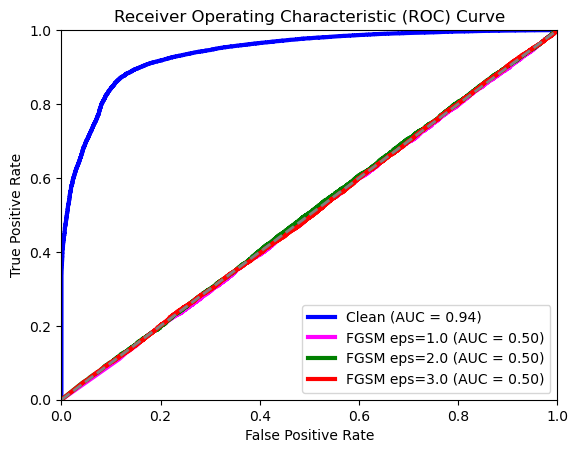

In [51]:
plt.figure()
plt.plot(FP_clean, TP_clean, color='blue', lw=3, label=f'Clean (AUC = {ROC_AUC_clean:.2f})')
plt.plot(FP_1dot0, TP_1dot0, color='magenta', lw=3, label=f'FGSM eps=1.0 (AUC = {ROC_AUC_1dot0:.2f})')
plt.plot(FP_2dot0, TP_2dot0, color='green', lw=3, label=f'FGSM eps=2.0 (AUC = {ROC_AUC_2dot0:.2f})')
plt.plot(FP_3dot0, TP_3dot0, color='red', lw=3, label=f'FGSM eps=3.0 (AUC = {ROC_AUC_3dot0:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [53]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#https://yangcha.github.io/EER-ROC/

def compute_eer(fpr, tpr):
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer


print(f'EER clean dataset : {compute_eer(FP_clean, TP_clean)}\n'
      f'EER eps = 1.0 : {compute_eer(FP_1dot0, TP_1dot0)}\n'
      f'EER eps = 2.0 : {compute_eer(FP_2dot0, TP_2dot0)}\n'
      f'EER eps = 3.0 : {compute_eer(FP_3dot0, TP_3dot0)}')

EER clean dataset : 0.1244051665537043
EER eps = 1.0 : 0.5015810400429546
EER eps = 2.0 : 0.4970570739803394
EER eps = 3.0 : 0.5039447731755413


***
## % of audios with different predictions (wrt clean dataset)

In [54]:
def percentage_different(list1, list2):
    if len(list1) != len(list2):
        raise ValueError('Lists have different lengths')
    num_different = sum(1 for x,y in zip(list1, list2) if x!=y)
    total_elements = len(list1)
    percentage = (num_different/total_elements)*100
    return percentage

print(f'The % of audios with different predictions for eps = 1.0 is {percentage_different(GT_labels, pred_labels_1dot0):.2f}%\n'
      f'The % of audios with different predictions for eps = 2.0 is {percentage_different(GT_labels, pred_labels_2dot0):.2f}%\n'
      f'The % of audios with different predictions for eps = 3.0 is {percentage_different(GT_labels, pred_labels_3dot0):.2f}%')

The % of audios with different predictions for eps = 1.0 is 58.48%
The % of audios with different predictions for eps = 2.0 is 77.08%
The % of audios with different predictions for eps = 3.0 is 88.14%


***
## Confusion matrix
* TN true negative, actual class was 0 (BF) and predicted as 0
* FP false positive, actual class was 0, but predicted as 1 (deep fake)
* FN false negative, actual class was 1, but predicted as 0
* TP true positive, actual class was 1 and predicted as 1

In [55]:
from sklearn.metrics import confusion_matrix

# [ TN    FP
#   FN    TP ]

In [56]:
cm = confusion_matrix(GT_labels, pred_labels_clean)
print(cm)

[[ 6848   507]
 [15775 48107]]


In [57]:
cm = confusion_matrix(GT_labels, pred_labels_1dot0)
print(cm)

[[ 3434  3921]
 [37739 26143]]


In [58]:
cm = confusion_matrix(GT_labels, pred_labels_2dot0)
print(cm)

[[  184  7171]
 [47736 16146]]


In [59]:
cm = confusion_matrix(GT_labels, pred_labels_3dot0)
print(cm)

[[    4  7351]
 [55440  8442]]


## Computing the indices of true positives
aka those audios with GT=1 and prediction=1, which means they are DF and the model correctly identified them as DF


In [21]:
# def find_TP(list1, list2):
#     if len(list1) != len(list2):
#         raise ValueError
#     list = []
#     for i in range(len(list1)):
#         if (list1[i]==1 & list2[i]==1):
#             list.append(i)
#     return list    
# 
# TP_indices = find_TP(true_labels, pred_labels)
# TP_indices[:10]